In [ ]:
Grafos que ejecutar:
graphs = [
    nx.random_regular_graph(d=3, n=28, seed=102),
    nx.random_regular_graph(d=3, n=30, seed=264),
    nx.random_regular_graph(d=3, n=32, seed=7),
    nx.random_regular_graph(d=3, n=80, seed=68),
    nx.random_regular_graph(d=3, n=100, seed=12),
    nx.random_regular_graph(d=3, n=120, seed=8),
]
opt = [40, 43, 46, 106, 135, 163]


In [10]:
#Primer grafo: 
import dimod
import networkx as nx
import matplotlib.pyplot as plt
import time
# Crear el grafo regular aleatorio
G = nx.random_regular_graph(d=3, n=28, seed=102)
opt=40
num_reads=1000
# Asignar peso 1 a todas las aristas
edges = {(u, v): 1 for u, v in G.edges}

# Construir el QUBO para Max-Cut

Q = {}
for (u, v), weight in edges.items():
    Q[(u, u)] = Q.get((u, u), 0) - weight
    Q[(v, v)] = Q.get((v, v), 0) - weight
    Q[(u, v)] = Q.get((u, v), 0) + 2 * weight
    

# Medir tiempo de ejecución
start_time = time.time()

# Sampler de recocido simulado
sampler = dimod.SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(Q, num_reads=num_reads)

end_time = time.time()

# Calcular tiempo total de ejecución en milisegundos
execution_time = (end_time - start_time) * 1000  # ms

# Tiempo por muestra
t_sample = execution_time / 1000  # num_reads = 1000

# Mostrar resumen de resultados
print("Tiempo de ejecución:", execution_time)
print("Resultados:")
print(sampleset)


Tiempo de ejecución: 40987.54358291626
Resultados:
     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 27 energy num_oc.
0    0  1  0  0  1  1  1  0  1  1  1  0  0  0  1  1  1  0 ...  1  -40.0       1
2    0  1  0  0  1  1  1  0  1  1  1  0  0  0  0  1  1  0 ...  1  -40.0       1
4    1  0  1  1  0  0  0  1  0  0  0  1  1  1  1  0  0  1 ...  0  -40.0       1
5    0  1  0  0  1  1  1  0  1  1  1  0  0  0  1  1  1  0 ...  1  -40.0       1
6    0  1  0  0  1  1  1  0  1  1  1  0  0  0  0  1  1  0 ...  1  -40.0       1
7    0  1  0  0  1  1  1  0  1  1  1  0  0  0  0  1  1  0 ...  1  -40.0       1
8    1  0  1  1  0  0  0  1  0  0  0  1  1  1  0  0  0  1 ...  0  -40.0       1
9    1  0  1  1  0  0  0  1  0  0  0  1  1  1  0  0  0  1 ...  0  -40.0       1
10   1  0  1  1  0  0  0  1  0  0  0  1  1  1  0  0  0  1 ...  0  -40.0       1
11   1  0  1  1  0  0  0  1  0  0  0  1  1  1  1  0  0  1 ...  0  -40.0       1
12   0  1  0  0  1  1  1  0  1  1  1  0  0  0  1  1  1  0 ...  1  -40

In [11]:
best_solution = sampleset.first.sample
print("Mejor resultado: ",best_solution)

Mejor resultado:  {0: np.int8(0), 1: np.int8(1), 2: np.int8(0), 3: np.int8(0), 4: np.int8(1), 5: np.int8(1), 6: np.int8(1), 7: np.int8(0), 8: np.int8(1), 9: np.int8(1), 10: np.int8(1), 11: np.int8(0), 12: np.int8(0), 13: np.int8(0), 14: np.int8(1), 15: np.int8(1), 16: np.int8(1), 17: np.int8(0), 18: np.int8(0), 19: np.int8(0), 20: np.int8(1), 21: np.int8(0), 22: np.int8(0), 23: np.int8(1), 24: np.int8(0), 25: np.int8(0), 26: np.int8(1), 27: np.int8(1)}


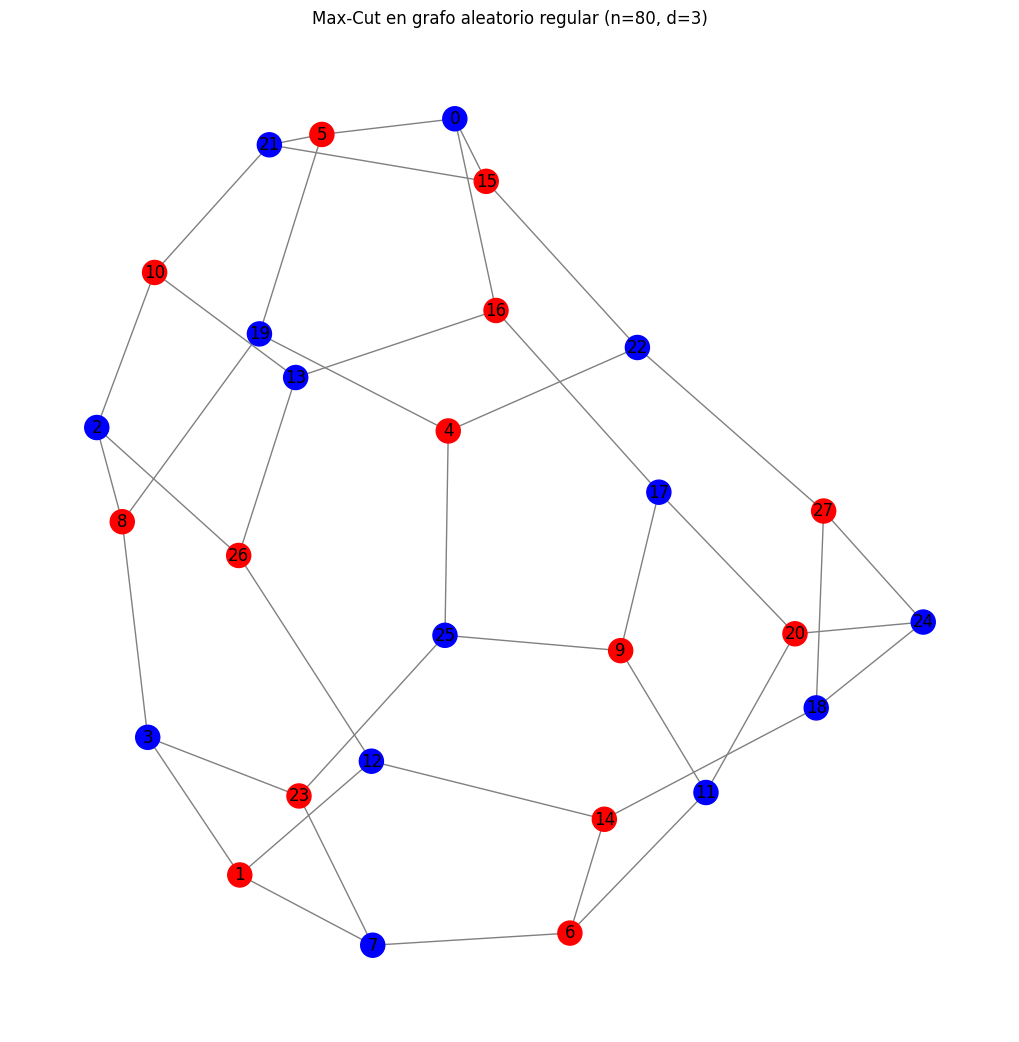

In [12]:

# Visualizar con colores
node_colors = ['red' if best_solution[node] == 1 else 'blue' for node in G.nodes]

# Dibujar el grafo
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=300)
plt.title("Max-Cut en grafo aleatorio regular (n=80, d=3)")
plt.show()


In [13]:
def compute_cut_size(G, solution):
    return sum(1 for u, v in G.edges if solution[u] != solution[v])

# Obtener todas las soluciones del sampleset
all_solutions = sampleset.record.sample
cut_values = []

#print("\nValores de corte para cada solución:")
for i, sol in enumerate(all_solutions):
    # Convertir de array a diccionario {nodo: valor}
    sol_dict = dict(zip(G.nodes, sol))
    cut = compute_cut_size(G, sol_dict)
    cut_values.append(cut)
    #print(f"  Solución {i+1}: corte = {cut}")

print(f"\nValor máximo de corte encontrado: {max(cut_values)}")



Valor máximo de corte encontrado: 40


In [14]:
import numpy as np
import pandas as pd

# Parámetros

# Calcular P_GS
best_cut_value = max(cut_values)
opt_solutions_count = sum(1 for c in cut_values if c == opt)
p_gs = opt_solutions_count / num_reads

# Calcular TTS (Time to Solution con 99% de probabilidad de éxito)
if p_gs == 0:
    tts = float("inf")
else:
    tts = t_sample * (np.log(1 - 0.99) / np.log(1 - p_gs))

# Mostrar resultados
df = pd.DataFrame({
    "Instance": ["28-nodes Max-Cut"],
    "Opt": [opt],
    "Max encontrado": [best_cut_value],
    "P_GS": [p_gs],
    "t_sample (ms)": [t_sample],
    "TTS (ms)": [tts]
})

print("\nMétricas de rendimiento:")
display(df)



Métricas de rendimiento:


,Instance,Opt,Max encontrado,P_GS,t_sample (ms),TTS (ms)
0,28-nodes Max-Cut,40,40,0.85,40.987544,99.495348


In [79]:
import dimod
import networkx as nx
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd

def maxcut(G, reads, weight=1):
    edges = {(u, v): 1 for u, v in G.edges}
    Q = {}
    for (u, v), weight in edges.items():
        Q[(u, u)] = Q.get((u, u), 0) - weight
        Q[(v, v)] = Q.get((v, v), 0) - weight
        Q[(u, v)] = Q.get((u, v), 0) + 2 * weight
        
        
    # Medir tiempo de ejecución
    start_time = time.time()
    
    # Sampler de recocido simulado
    sampler = dimod.SimulatedAnnealingSampler()
    sampleset = sampler.sample_qubo(Q, num_reads=reads)
    
    end_time = time.time()
    
    # Calcular tiempo total de ejecución en milisegundos
    execution_time = (end_time - start_time) * 1000  # ms
    
    # Tiempo por muestra
    t_sample = execution_time / reads
    
    # Mostrar resumen de resultados
    print("Tiempo de ejecución (ms):", execution_time)
    print("Resultados:")
    print(sampleset, "\n")

    return sampleset, t_sample

def maxcut_graph(G, sampleset):
    best_solution = sampleset.first.sample
    # Visualizar con colores
    node_colors = ['red' if best_solution[node] == 1 else 'blue' for node in G.nodes]
    n = G.number_of_nodes()
    d = G.degree[0]  
    # Dibujar el grafo
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=300)
    plt.title(f"Max-Cut en grafo aleatorio regular (n={n}, d={d})")
    plt.show()


def compute_cut_size(G, solution):
    return sum(1 for u, v in G.edges if solution[u] != solution[v])

def best_solution(G, sampleset):
    # Obtener todas las soluciones del sampleset
    all_solutions = sampleset.record.sample
    cut_values = []
    
    #print("\nValores de corte para cada solución:")
    for i, sol in enumerate(all_solutions):
        # Convertir de array a diccionario {nodo: valor}
        sol_dict = dict(zip(G.nodes, sol))
        cut = compute_cut_size(G, sol_dict)
        cut_values.append(cut)
        #print(f"  Solución {i+1}: corte = {cut}")
    
    print(f"\nValor máximo de corte encontrado: {max(cut_values)}")
    return cut_values


def metrics(cut_values, opt, t_sample, num_reads):
    # Parámetros
    
    # Calcular P_GS
    best_cut_value = max(cut_values)
    opt_solutions_count = sum(1 for c in cut_values if c == opt)
    p_gs = opt_solutions_count / num_reads

    # Calcular TTS (Time to Solution con 99% de probabilidad de éxito)
    if p_gs == 0:
        tts = float("inf")
    elif p_gs == 1:
        tts = t_sample
    else:
        tts = t_sample * (np.log(1 - 0.99) / np.log(1 - p_gs))
    
    # Mostrar resultados
    df = pd.DataFrame({
        "Instance": ["28-nodes Max-Cut"],
        "Opt": [opt],
        "Max encontrado": [best_cut_value],
        "P_GS": [p_gs],
        "t_sample (ms)": [t_sample],
        "TTS (ms)": [tts]
    })
    
    print("\nMétricas de rendimiento:")
    display(df)


Tiempo de ejecución: 42494.524002075195
Resultados:
     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 27 energy num_oc.
0    1  0  1  1  0  0  0  1  0  0  0  1  1  1  1  0  0  1 ...  0  -40.0       1
3    1  0  1  1  0  0  0  1  0  0  0  1  1  1  0  0  0  1 ...  0  -40.0       1
4    1  0  1  1  0  0  0  1  0  0  0  1  1  1  1  0  0  1 ...  0  -40.0       1
5    0  1  0  0  1  1  1  0  1  1  1  0  0  0  0  1  1  0 ...  1  -40.0       1
6    0  1  0  0  1  1  1  0  1  1  1  0  0  0  1  1  1  0 ...  1  -40.0       1
7    0  1  0  0  1  1  1  0  1  1  1  0  0  0  1  1  1  0 ...  1  -40.0       1
8    0  1  0  0  1  1  1  0  1  1  1  0  0  0  0  1  1  0 ...  1  -40.0       1
9    1  0  1  1  0  0  0  1  0  0  0  1  1  1  1  0  0  1 ...  0  -40.0       1
10   1  0  1  1  0  0  0  1  0  0  0  1  1  1  1  0  0  1 ...  0  -40.0       1
11   0  1  0  0  1  1  1  0  1  1  1  0  0  0  0  1  1  0 ...  1  -40.0       1
12   0  1  0  0  1  1  1  0  1  1  1  0  0  0  1  1  1  0 ...  1  -4

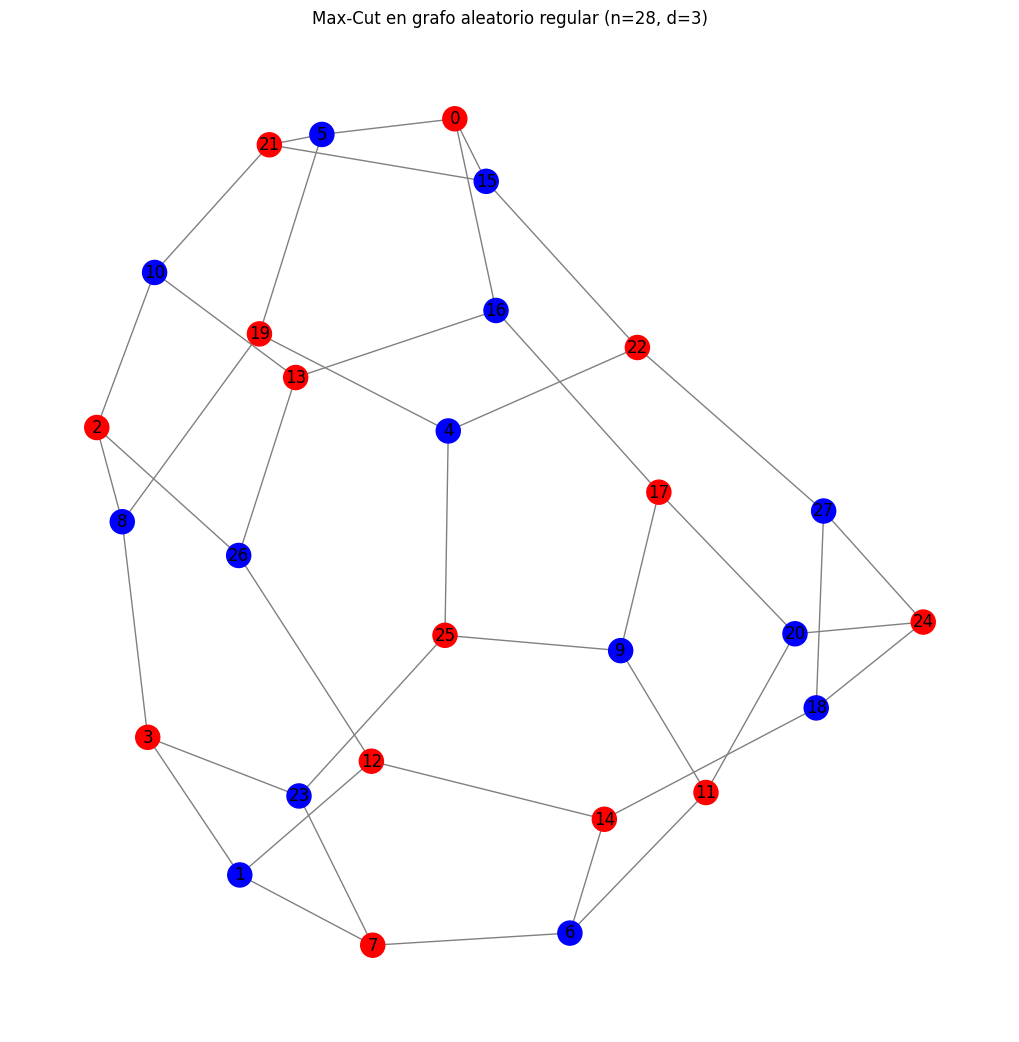


Valor máximo de corte encontrado: 40

Métricas de rendimiento:


,Instance,Opt,Max encontrado,P_GS,t_sample (ms),TTS (ms)
0,28-nodes Max-Cut,40,40,0.848,42.494524,103.878729


In [81]:
# Grafo que ejecutar 1
G = nx.random_regular_graph(d=3, n=28, seed=102)
opt=40
num_reads=1000

# Ejecutar Max-Cut y obtener muestras y tiempo por muestra
sampleset, t_sample = maxcut(G, num_reads)

# Dibujar la mejor solución encontrada
maxcut_graph(G, sampleset)

# Mostrar el mejor valor de corte obtenido
values=best_solution(G, sampleset)

# Mostrar métricas
metrics(values, opt, t_sample, num_reads)

Tiempo de ejecución: 45149.50466156006
Resultados:
     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 29 energy num_oc.
0    1  1  0  1  0  0  0  0  0  0  0  1  1  1  1  0  1  1 ...  1  -43.0       1
2    0  0  1  0  1  1  1  1  1  1  1  0  0  0  0  1  0  0 ...  0  -43.0       1
3    1  1  0  1  0  0  0  0  0  0  0  1  1  1  1  0  1  1 ...  1  -43.0       1
4    1  1  0  1  0  0  0  0  0  0  0  1  1  1  1  0  1  1 ...  1  -43.0       1
5    1  1  0  1  0  0  0  0  0  0  0  1  1  1  1  0  1  1 ...  1  -43.0       1
6    1  1  0  1  0  0  0  0  0  0  0  1  1  1  1  0  1  1 ...  1  -43.0       1
7    0  0  1  0  1  1  1  1  1  1  1  0  0  0  0  1  0  0 ...  0  -43.0       1
9    1  1  0  1  0  0  0  0  0  0  0  1  1  1  1  0  1  1 ...  1  -43.0       1
11   0  0  1  0  1  1  1  1  1  1  1  0  0  0  0  1  0  0 ...  0  -43.0       1
12   1  1  0  1  0  0  0  0  0  0  0  1  1  1  1  0  1  1 ...  1  -43.0       1
13   0  0  1  0  1  1  1  1  1  1  1  0  0  0  0  1  0  0 ...  0  -43

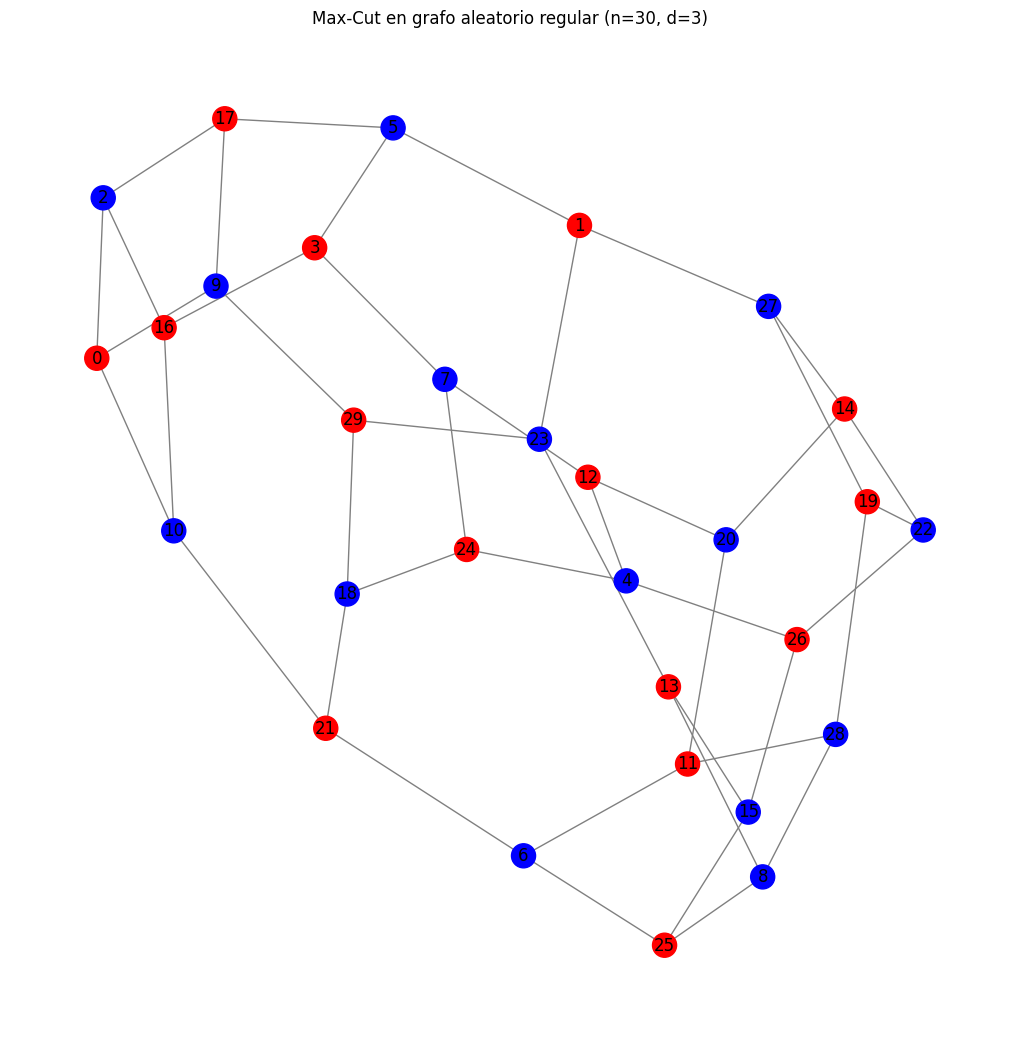


Valor máximo de corte encontrado: 43

Métricas de rendimiento:


,Instance,Opt,Max encontrado,P_GS,t_sample (ms),TTS (ms)
0,28-nodes Max-Cut,43,43,0.802,45.149505,128.386948


In [82]:
# Grafo que ejecutar 2
G = nx.random_regular_graph(d=3, n=30, seed=264)
opt=43
num_reads=1000

# Ejecutar Max-Cut y obtener muestras y tiempo por muestra
sampleset, t_sample = maxcut(G, num_reads)

# Dibujar la mejor solución encontrada
maxcut_graph(G, sampleset)

# Mostrar el mejor valor de corte obtenido
values=best_solution(G, sampleset)

# Mostrar métricas
metrics(values, opt, t_sample, num_reads)

Tiempo de ejecución: 47857.28216171265
Resultados:
     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 31 energy num_oc.
0    0  0  0  0  1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...  1  -46.0       1
1    0  0  0  0  1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...  1  -46.0       1
2    1  1  1  1  0  0  0  0  1  0  0  0  0  0  0  0  1  1 ...  0  -46.0       1
3    1  1  1  1  0  0  0  0  1  0  0  0  0  0  0  0  1  1 ...  0  -46.0       1
5    1  1  1  1  0  0  0  0  1  0  0  0  0  0  0  0  1  1 ...  0  -46.0       1
6    0  0  0  0  1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...  1  -46.0       1
7    0  0  0  0  1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...  1  -46.0       1
10   1  1  1  1  0  0  0  0  1  0  0  0  0  0  0  0  1  1 ...  0  -46.0       1
11   0  0  0  0  1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...  1  -46.0       1
13   0  0  0  0  1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...  1  -46.0       1
14   0  0  0  0  1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...  1  -46

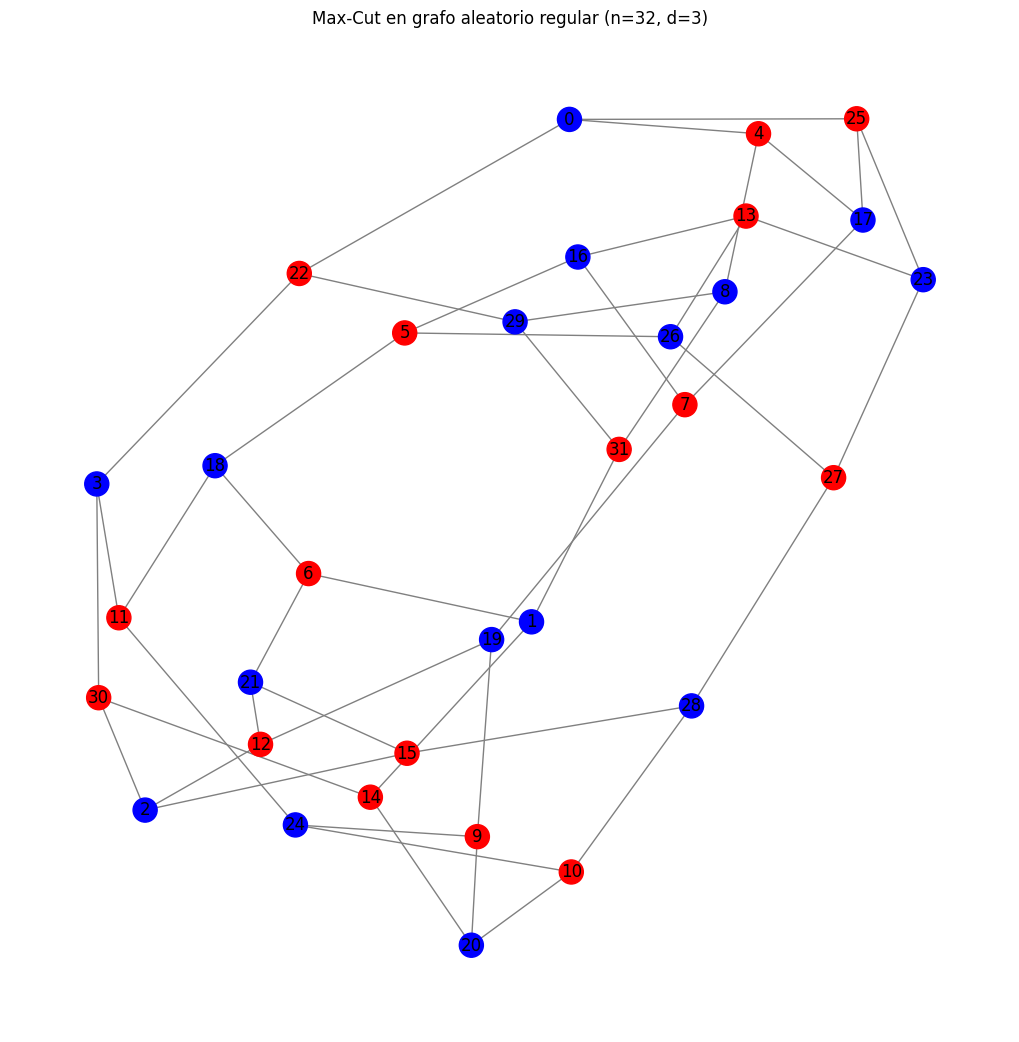


Valor máximo de corte encontrado: 46

Métricas de rendimiento:


,Instance,Opt,Max encontrado,P_GS,t_sample (ms),TTS (ms)
0,28-nodes Max-Cut,46,46,0.796,47.857282,138.642449


In [83]:
# Grafo que ejecutar 3
G = nx.random_regular_graph(d=3, n=32, seed=7)
opt=46
num_reads=1000

# Ejecutar Max-Cut y obtener muestras y tiempo por muestra
sampleset, t_sample = maxcut(G, num_reads)

# Dibujar la mejor solución encontrada
maxcut_graph(G, sampleset)

# Mostrar el mejor valor de corte obtenido
values=best_solution(G, sampleset)

# Mostrar métricas
metrics(values, opt, t_sample, num_reads)

Tiempo de ejecución: 118421.1232662201
Resultados:
     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 79 energy num_oc.
117  1  0  1  1  0  1  1  0  1  1  1  0  1  0  1  1  0  0 ...  1 -106.0       1
120  1  0  1  1  0  1  1  0  1  1  1  0  1  0  1  1  0  0 ...  1 -106.0       1
255  0  1  0  0  1  0  0  1  0  0  0  1  0  1  0  0  1  1 ...  0 -106.0       1
834  1  0  1  1  0  1  1  0  1  1  1  0  1  0  1  1  0  0 ...  1 -106.0       1
861  0  1  0  0  1  0  0  1  0  0  0  1  0  1  0  0  1  1 ...  0 -106.0       1
2    1  0  1  1  1  1  1  0  1  1  0  1  0  1  1  1  0  0 ...  1 -105.0       1
26   1  0  1  1  0  1  1  0  1  1  1  0  1  1  1  1  0  0 ...  1 -105.0       1
41   0  1  1  0  0  1  0  0  0  0  0  1  1  1  0  1  1  0 ...  0 -105.0       1
47   1  0  1  1  0  1  1  0  1  1  1  0  1  1  1  1  0  0 ...  1 -105.0       1
77   1  0  1  1  0  1  1  0  1  1  1  0  1  0  1  1  0  0 ...  1 -105.0       1
90   0  0  1  1  0  1  0  0  1  1  1  0  1  0  1  1  0  0 ...  0 -105

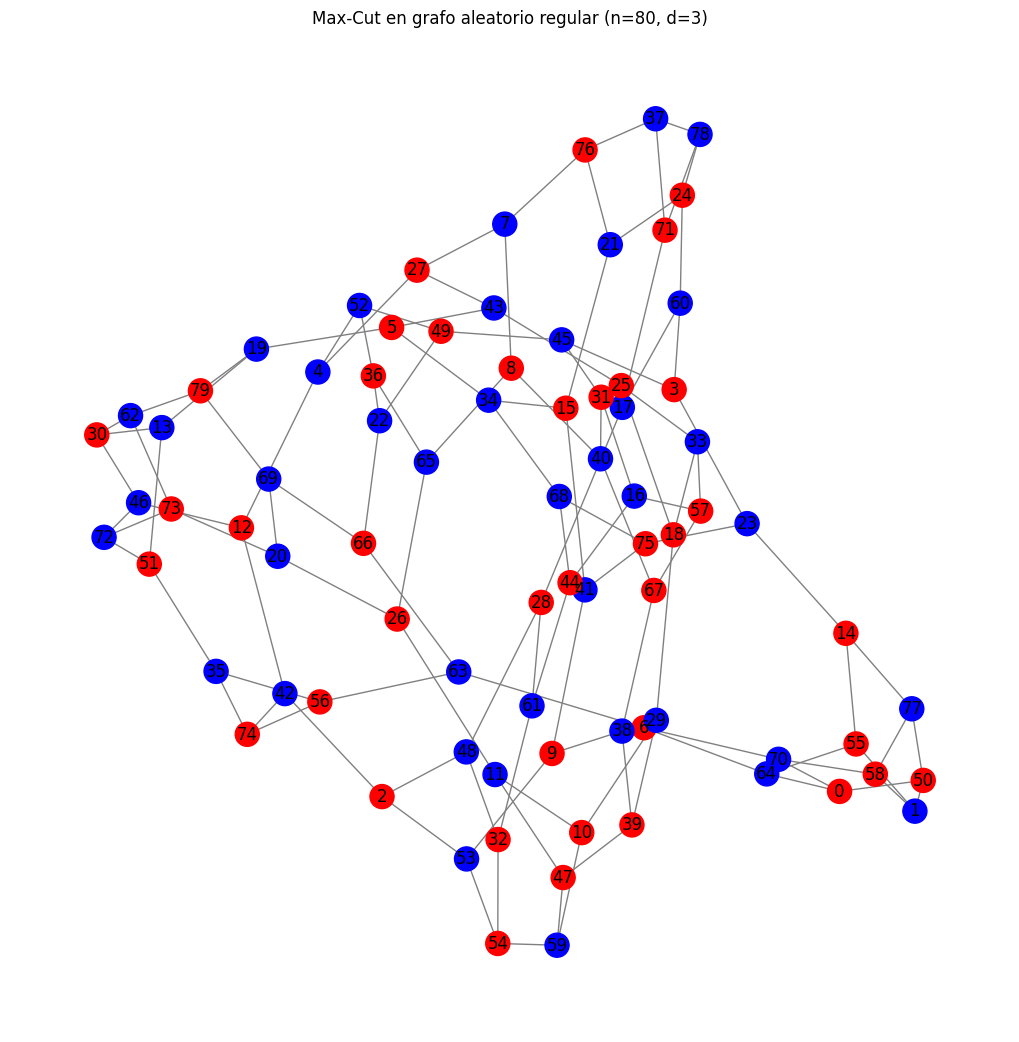


Valor máximo de corte encontrado: 106

Métricas de rendimiento:


,Instance,Opt,Max encontrado,P_GS,t_sample (ms),TTS (ms)
0,28-nodes Max-Cut,106,106,0.005,118.421123,108796.982739


In [84]:
# Grafo que ejecutar 4
G = nx.random_regular_graph(d=3, n=80, seed=68)
opt=106
num_reads=1000

# Ejecutar Max-Cut y obtener muestras y tiempo por muestra
sampleset, t_sample = maxcut(G, num_reads)

# Dibujar la mejor solución encontrada
maxcut_graph(G, sampleset)

# Mostrar el mejor valor de corte obtenido
values=best_solution(G, sampleset)

# Mostrar métricas
metrics(values, opt, t_sample, num_reads)

Tiempo de ejecución: 147002.00366973877
Resultados:
     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 99 energy num_oc.
27   1  0  1  1  0  1  0  1  0  1  1  1  1  1  1  1  0  0 ...  0 -135.0       1
34   1  0  1  1  0  1  0  1  0  1  1  1  1  1  1  1  0  0 ...  0 -135.0       1
61   1  0  1  1  0  1  0  1  0  1  1  1  1  1  1  1  0  0 ...  0 -135.0       1
66   1  0  1  1  0  1  0  1  0  1  1  1  1  1  1  1  0  0 ...  0 -135.0       1
135  0  1  0  0  1  0  1  0  1  0  0  0  0  0  0  0  1  1 ...  1 -135.0       1
180  0  1  0  0  1  0  1  0  1  0  0  0  0  0  0  0  1  1 ...  1 -135.0       1
303  0  1  0  0  1  0  1  0  1  0  0  0  0  0  0  0  1  1 ...  1 -135.0       1
441  0  1  0  0  1  0  1  0  1  0  0  0  0  0  0  0  1  1 ...  1 -135.0       1
454  0  1  0  0  1  0  1  0  1  0  0  0  0  0  0  0  1  1 ...  1 -135.0       1
574  1  0  1  1  0  1  0  1  0  1  1  1  1  1  1  1  0  0 ...  0 -135.0       1
929  0  1  0  0  1  0  1  0  1  0  0  0  0  0  0  0  1  1 ...  1 -13

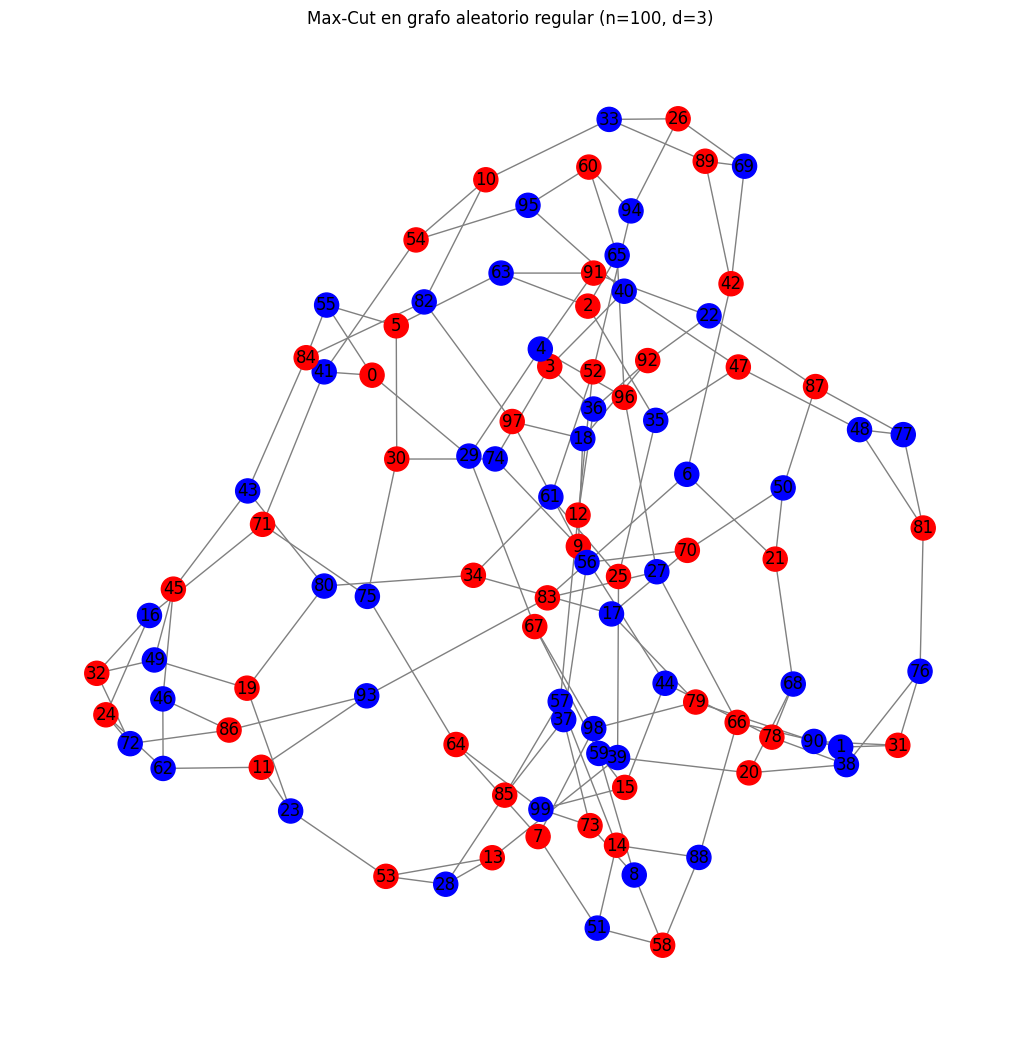


Valor máximo de corte encontrado: 135

Métricas de rendimiento:


,Instance,Opt,Max encontrado,P_GS,t_sample (ms),TTS (ms)
0,28-nodes Max-Cut,135,135,0.012,147.002004,56074.938031


In [85]:
# Grafo que ejecutar 5
G = nx.random_regular_graph(d=3, n=100, seed=12)
opt=135
num_reads=1000

# Ejecutar Max-Cut y obtener muestras y tiempo por muestra
sampleset, t_sample = maxcut(G, num_reads)

# Dibujar la mejor solución encontrada
maxcut_graph(G, sampleset)

# Mostrar el mejor valor de corte obtenido
values=best_solution(G, sampleset)

# Mostrar métricas
metrics(values, opt, t_sample, num_reads)

Tiempo de ejecución: 170661.98658943176
Resultados:
     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 119 energy num_oc.
7    1  1  0  1  1  1  1  0  1  0  1  0  0  0  0  1  1 ...   1 -163.0       1
8    0  0  0  0  0  1  1  1  1  1  0  0  1  1  1  0  0 ...   0 -163.0       1
17   0  0  0  0  0  1  1  1  1  1  0  0  1  1  1  1  0 ...   0 -163.0       1
53   1  1  1  1  1  0  0  0  0  0  1  1  0  0  0  1  1 ...   1 -163.0       1
65   1  1  0  1  1  1  1  0  1  1  1  0  0  0  0  1  1 ...   1 -163.0       1
67   1  1  0  1  1  1  1  0  1  0  1  0  0  0  0  1  1 ...   1 -163.0       1
77   0  0  1  0  0  1  0  1  0  0  0  1  1  1  1  1  0 ...   0 -163.0       1
81   0  0  1  0  0  1  0  1  0  1  0  1  1  1  1  0  0 ...   0 -163.0       1
115  0  0  1  0  0  0  0  1  0  0  0  1  1  1  1  1  0 ...   0 -163.0       1
116  0  0  1  0  0  1  0  1  0  1  0  1  1  1  1  0  0 ...   0 -163.0       1
126  1  1  1  1  1  0  0  0  0  0  1  1  0  0  0  1  1 ...   1 -163.0       1
137  1  1  1

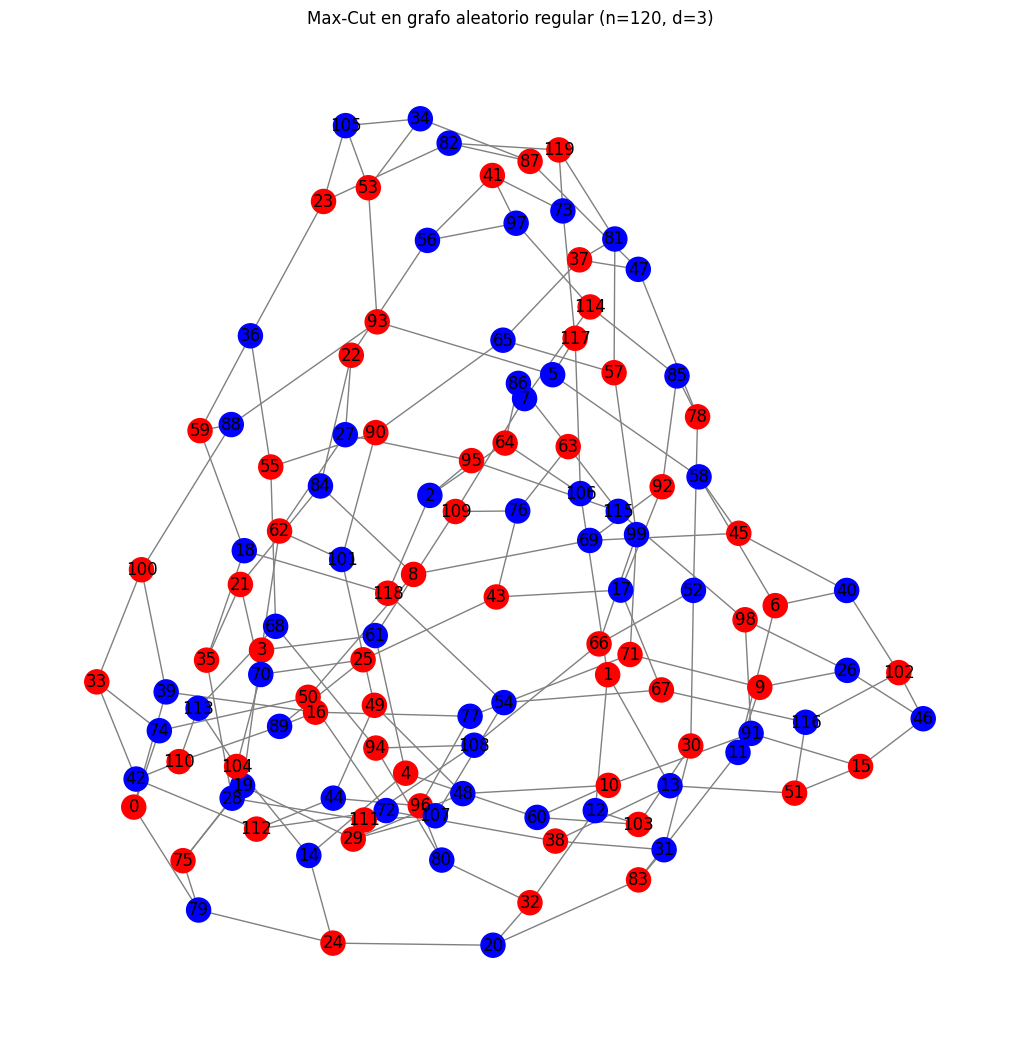


Valor máximo de corte encontrado: 163

Métricas de rendimiento:


,Instance,Opt,Max encontrado,P_GS,t_sample (ms),TTS (ms)
0,28-nodes Max-Cut,163,163,0.065,170.661987,11693.827011


In [86]:
# Grafo que ejecutar 5
G = nx.random_regular_graph(d=3, n=120, seed=8)
opt=163
num_reads=1000

# Ejecutar Max-Cut y obtener muestras y tiempo por muestra
sampleset, t_sample = maxcut(G, num_reads)

# Dibujar la mejor solución encontrada
maxcut_graph(G, sampleset)

# Mostrar el mejor valor de corte obtenido
values=best_solution(G, sampleset)

# Mostrar métricas
metrics(values, opt, t_sample, num_reads)